### ML Workshop 3: Crypto trading
Please do not take what we are showing here as financial advice! As you can probably seen this approach is relatively simplistic and will likely cause you to lose money overtime.

In [4]:
import numpy as np
import pandas as pd
from datetime import datetime
import time
import os

import ta
import ccxt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import RobustScaler

import matplotlib.pyplot as plt
plt.style.use('bmh') # https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html

# As a general note, some parts of the code are not used anywhere, but I included them as they may be useful for
# extensions, e.g. making a live trader.

class ExchangeInterface:
    def __init__(self, exchange, market, key=None, secret=None, phrase=None):
        # Setting up CCXT client
        exchange_class = getattr(ccxt, exchange)
        if exchange == 'coinbasepro':
            if key:
                self.client = exchange_class({
                    'apiKey': key,
                    'secret': secret,
                    'password': phrase,
                    'enableRateLimit': True,
                    'rateLimit': 400
                })
            else:
                self.client = exchange_class({
                    'enableRateLimit': True,
                    'rateLimit': 400
                })
        elif exchange == 'binance':
            if key:
                self.client = exchange_class({
                    'apiKey': key,
                    'secret': secret,
                    'nonce': ccxt.Exchange.milliseconds,
                    'enableRateLimit': True,
                    'rateLimit': 200
                })
            else:
                self.client = exchange_class({
                    'nonce': ccxt.Exchange.milliseconds,
                    'enableRateLimit': True,
                    'rateLimit': 200
                })

        self.client.load_markets()

        self.exchange = exchange
        self.market = market
        market_split = self.market.split('/')
        self.base = market_split[0]
        self.quote = market_split[1]

    def get_latest_price(self):
        tick = self.client.fetch_ticker(self.market)
        return tick['last']

    def get_candles(self, res, since=None):
        if since:
            resp = self.client.fetch_ohlcv(self.market, res, since=since)
        else:
            resp = self.client.fetch_ohlcv(self.market, res)
        df = pd.DataFrame(resp, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        return df


class TA:
    def __init__(self):
        pass

    def add_all_ta(self, df):
        df_ta = ta.add_all_ta_features(df, open='open', high='high', low='low', close='close', volume='volume', fillna=True)
        return df_ta


class Trainer:
    def __init__(self, features, window_size, fee, num_train, num_test):
        self.feats = features
        self.window_size = window_size
        self.fee = fee
        self.num_train = num_train
        self.num_test = num_test
        self.num_feats = features.shape[1]
        self.classes = None
        self.feats_scaled = None
        self.model = None

    def label_data(self):
        # If open price of next period is lower than closing price (accounting for fees), then we want to buy at the
        # open and sell at the close.  If vice versa, then we want to sell at the open and buy at the close.  Otherwise,
        # we want to do nothing.
        y = []
        for ii in range(len(self.feats)-1):
            if self.feats['close'][ii+1]*(1-self.fee) - self.feats['open'][ii+1]*(1+self.fee) > 0:
                y.append(1)
            elif self.feats['open'][ii+1]*(1-self.fee) - self.feats['close'][ii+1]*(1+self.fee) > 0:
                y.append(2)
            else:
                y.append(0)

        return y

    def one_hot_encode(self, x):
        y = np.zeros((x.size, x.max() + 1))
        y[np.arange(x.size), x] = 1


        return y

    def make_model(self):
        # This creates the LSTM model.  Lots of room for innovation here.
        self.model = Sequential()
        self.model.add(LSTM(
            units=100,
            activation='tanh',
            input_shape=(self.window_size, self.num_feats)))
        self.model.add(Dense(units=3,
                             activation='softmax'))
        self.model.compile(loss='categorical_crossentropy',
                           optimizer=Adam(lr=0.001),
                           metrics=['accuracy'])
        self.model.summary()

        return self.model

    def split_data(self):
        train_X = self.feats_scaled.iloc[:self.num_train]
        train_y = self.classes[:self.num_train]
        test_X = self.feats_scaled.iloc[self.num_train:self.num_train+self.num_test]
        test_y = self.classes[self.num_train:self.num_train+self.num_test]

        return train_X, train_y, test_X, test_y

    def format_data(self, X):
        # Creating a 3D array to hold all the data samples
        X_tensor = np.zeros((X.shape[0]-self.window_size, self.window_size, self.num_feats))
        for ii in range(X_tensor.shape[0]-self.window_size):
            X_tensor[ii,:,:] = X[ii:ii+self.window_size,:]

        return X_tensor

    def train_model(self):
        train_X, train_y, test_X, test_y = self.split_data()

        # Training data
        train_X = np.array(train_X)
        train_X = self.format_data(train_X)
        train_y = np.array(train_y[self.window_size:])
        train_y = self.one_hot_encode(train_y)

        # Testing data
        test_X = np.array(test_X)
        test_X = self.format_data(test_X)
        test_y = np.array(test_y[self.window_size:])
        test_y = self.one_hot_encode(test_y)

        # Train the model
        training_results = self.model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=10, batch_size=1)

        return training_results

    def visualize_training_results(self, results):
        history = results.history
        plt.figure(figsize=(10, 5))
        plt.plot(history['val_loss'])
        plt.plot(history['loss'])
        plt.legend(['val_loss', 'loss'])
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(history['val_accuracy'])
        plt.plot(history['accuracy'])
        plt.legend(['val_accuracy', 'accuracy'])
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.show()

class Backtester:
    def __init__(self, data, data_scaled, trainer, fee, init_BTC, init_USD, trade_size):
        self.data = data
        self.data_scaled = data_scaled
        self.trainer = trainer
        self.fee = fee

        self.init_BTC = init_BTC
        self.init_USD = init_USD
        self.trade_size = trade_size

    def backtest(self):
        tot_BTC = self.init_BTC
        tot_USD = self.init_USD

        action_names = ['hold', 'buy', 'sell']

        # Go through all data and run strategy at every data point
        plt.figure()
        for ii in range(trainer.window_size,len(self.data)-1):
            data_window = self.data_scaled.iloc[ii-trainer.window_size:ii]
            data_array = np.array(data_window)
            data_tensor = np.reshape(data_array, (1, self.trainer.window_size, self.trainer.num_feats))
            y = self.trainer.model.predict(data_tensor)
            best_action = np.argmax(y)

            # [0.2 0.9 0.6]

            if best_action == 1: # buy, then sell
                price_buy = self.data['open'].iloc[ii]
                price_sell = self.data['close'].iloc[ii]

                # Place buy
                tot_BTC += self.trade_size
                tot_USD -= self.trade_size*price_buy*(1+self.fee)

                # Place sell
                tot_BTC -= self.trade_size
                tot_USD += self.trade_size*price_sell*(1-self.fee)
            elif best_action == 2: # sell, then buy
                price_sell = self.data['open'].iloc[ii]
                price_buy = self.data['close'].iloc[ii]

                # Place sell
                tot_BTC -= self.trade_size
                tot_USD += self.trade_size * price_sell * (1 - self.fee)

                # Place buy
                tot_BTC += self.trade_size
                tot_USD -= self.trade_size * price_buy * (1 + self.fee)
            else: # hold
                pass

            t = self.data['timestamp'].iloc[ii]
            if action_names[best_action] == 'hold':
                c='r'
            elif action_names[best_action] == 'buy':
                c='g'
            else:
                c='b'

            plt.scatter(datetime.utcfromtimestamp(t/1000), tot_USD, color=c)
            #print('Backtest: {} - {}'.format(datetime.utcfromtimestamp(t/1000), action_names[best_action]))

        return tot_BTC, tot_USD

c:\Users\leoli\anaconda3\envs\py3-TF2\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\leoli\anaconda3\envs\py3-TF2\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               77200     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 77,503
Trainable params: 77,503
Non-trainable params: 0
_________________________________________________________________
Train on 290 samples, validate on 190 samples
Epoch 1/10
290/290 [==============================] - 14s 49ms/sample - loss: 1.0521 - accuracy: 0.4517 - val_loss: 1.0062 - val_accuracy: 0.4000
Epoch 2/10
290/290 [==============================] - 11s 38ms/sample - loss: 0.9645 - accuracy: 0.5069 - val_loss: 0.9784 - val_accuracy: 0.5158
Epoch 3/10
290/290 [==============================] - 11s 38ms/sample - loss: 0.9305 - accuracy: 0.4931 - val_loss: 0.9554 - val_accuracy: 0.5053
Epoch 4/10
290/290 [========

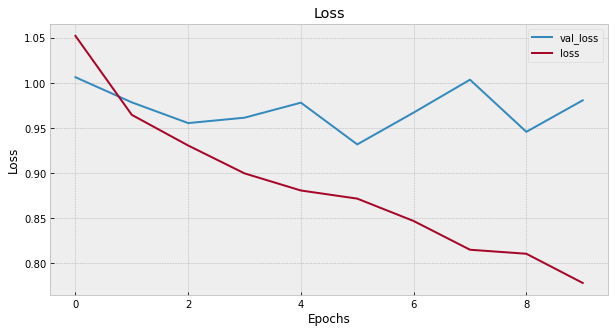

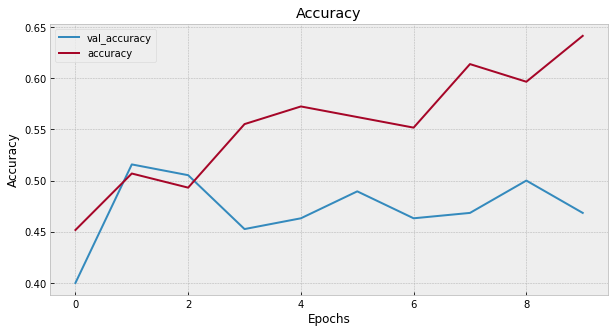

In [5]:
# Trading parameters
exchange = 'coinbasepro'
market = 'BTC/USD'
fee = 0.001

init_BTC = 1.0
init_USD = 30000.0

# key = os.environ["apiKey"]
# secret = os.environ["apiSecret"]
# passphrase = os.environ["passphrase"]

# Get data
exch_client = ExchangeInterface(exchange,
                                market)
start = 1546344000000 # Jan 1, 2019
# start = 1514808000000 # Jan 1, 2018
resp = exch_client.get_candles('1d', since=start)
candles = resp
while resp['timestamp'].iloc[-1] + 24*60*60*1000 < time.time()*1000:
    resp = exch_client.get_candles('1d', since=int(candles['timestamp'].iloc[-1]))
    candles = candles.append(resp, ignore_index=True)
candles = candles.drop_duplicates(subset=['timestamp'], ignore_index=True)

# Technical analysis
ta_client = TA()
features = ta_client.add_all_ta(candles)

# Prepare model and data
num_train = 300
num_test = 200
window_size = 10
trainer = Trainer(features, window_size, fee, num_train, num_test)
trainer.make_model()
trainer.classes = trainer.label_data()

# Scale data
scaler = RobustScaler()
scaler.fit(features.iloc[:num_train+num_test])
trainer.feats_scaled = pd.DataFrame(scaler.transform(features), columns=features.columns, index=features.index)

# Train model
results = trainer.train_model()
trainer.visualize_training_results(results)

Init BTC: 1.0000, Init USD: 30000.00
Final BTC: 1.0000, Final USD: 29305.52


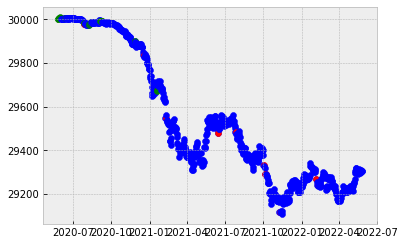

In [6]:
# Backtest model
backtester = Backtester(
    candles.iloc[num_train+num_test:],
    trainer.feats_scaled[num_train+num_test:],
    trainer,
    fee,
    init_BTC=init_BTC,
    init_USD=init_USD,
    trade_size=0.01
)

tot_BTC, tot_USD = backtester.backtest()
print('Init BTC: {:.4f}, Init USD: {:.2f}\nFinal BTC: {:.4f}, Final USD: {:.2f}'.format(init_BTC, init_USD, tot_BTC, tot_USD))

### Suggestion #1: Add more training data
With more training data either real or artificial, we can improve the accuracy of our model. One commonly used approach for images is adding noise to the inputs. Otherwise, if you're feeling ambitious you can try incorporating pricing data from other cryptocurrencies.

Try incorporating some of this code within your training

In [ ]:
### Function for adding some noise (this is untuned)
candles['open'] *= np.random.normal(0, .05)

#### Adding another input, e.g.
market = 'ETH/USD'
exch_client_2 = ExchangeInterface(exchange,
                                market)
start = 1546344000000 # Jan 1, 2019
resp = exch_client_2.get_candles('1d', since=start)
candles_2 = resp
while resp['timestamp'].iloc[-1] + 24*60*60*1000 < time.time()*1000:
    resp = exch_client.get_candles('1d', since=int(candles['timestamp'].iloc[-1]))
    candles_2 = candles.append(resp, ignore_index=True)
candles_2 = candles_2.drop_duplicates(subset=['timestamp'], ignore_index=True)
features_2 = ta_client.add_all_ta(candles_2)

#### Suggestion #2: Try using different Neural Networks
Our architecture is rather simple, try finding different network designs online and see if you can get better results.

In [ ]:
## Try out different Recurrent Neural Networks
self.model = Sequential()
self.model.add(LSTM(
    units=50,
    activation='tanh',
    input_shape=(self.window_size, self.num_feats)))
self.model.add(tf.keras.layers.GRU(
    units=50,
    activation='tanh',
    input_shape=(self.window_size, self.num_feats)))
self.model.add(Dense(units=3,
                        activation='softmax'))

## If you're feeling up for it, trying having the network predict the price directly
# and responding to that accordingly. THIS IS DIFFICULT
self.model.add(Dense(units=1, activation='linear'))
train_y = candles['close']